In [1]:
# Data manipulation and math computation
import pandas as pd
import numpy as np

# Data visualisation 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import networkx as nx 
%matplotlib inline

import operator
from collections import defaultdict

# For communities detection
import community

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [54]:
#load the data
df = pd.read_csv("Network.csv",sep=",")
print(df.shape)
df.head()

(5319, 28)


,Unnamed: 0,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,...,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Choice
0,0,17,0,17,190,228,302,3,0.583979,0.100503,...,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939,0
1,1,16,1,17,113,21591,1179,228,90.456506,25.798292,...,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337,0
2,2,2,2,1,788,7310,1215,101,25.503644,9.556347,...,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333,0
3,3,22,3,19,99,20,7,2,7.690824,0.277306,...,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634,0
4,4,21,4,22,307,45589,862,2641,148.854279,36.998884,...,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907,1


In [3]:
df.index = df['Unnamed: 0']
df.drop(columns=['Unnamed: 0'],inplace=True)
df.index.name = ''

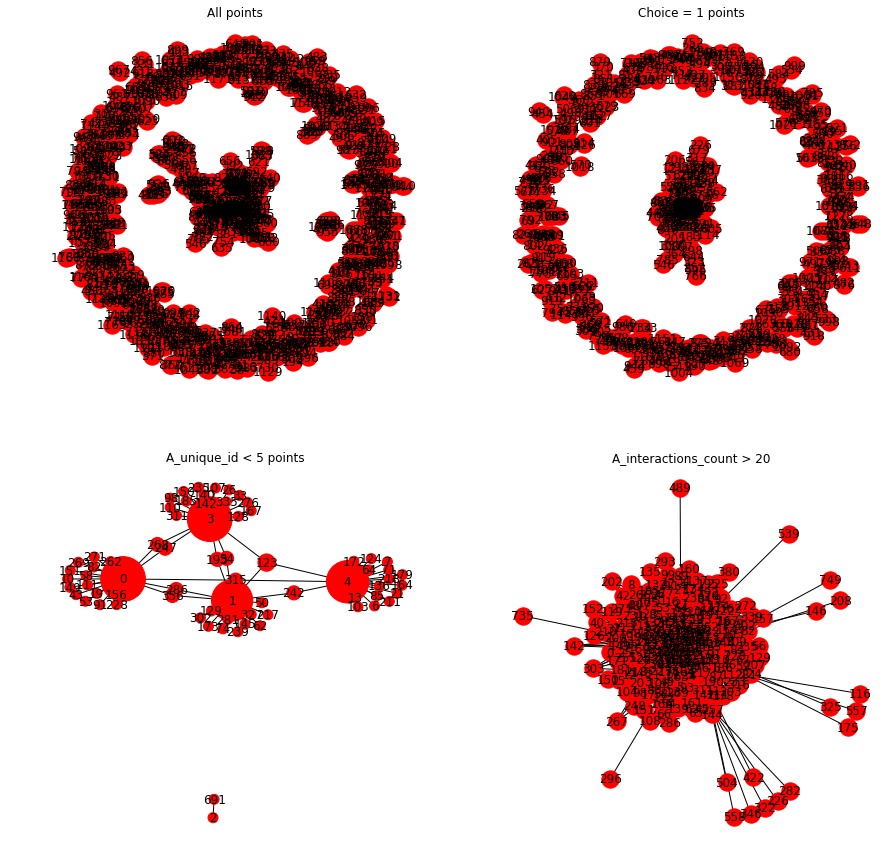

In [4]:
# Choose the variables to be involved into this study
network = df#train_df[['A_unique_id','B_unique_id','Choice','A_interactions_count','B_interactions_count','A_follower_count','A_following_count']]

# Build the graph for all points
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
G=nx.from_pandas_edgelist(network, 'A_unique_id', 'B_unique_id')
nx.draw(G,with_labels=True)
plt.title('All points')

# Reduce the amount of points and plot some subsets
# only for Choice=1
plt.subplot(2, 2, 2)
G_choice1=nx.from_pandas_edgelist(network.query('Choice == 1'), 'A_unique_id', 'B_unique_id')
nx.draw(G_choice1,with_labels=True)
plt.title('Choice = 1 points')

# For random n points
plt.subplot(2, 2, 3)
G_uniqueId=nx.from_pandas_edgelist(network.query('A_unique_id < 5'), 'A_unique_id', 'B_unique_id')
degree = G_uniqueId.degree()
nx.draw(G_uniqueId,node_size=[v * 100 for v in dict(degree).values()],with_labels=True)
plt.title('A_unique_id < 5 points')

# For large number of interactions of A
plt.subplot(2, 2, 4)
G_largeA_inter=nx.from_pandas_edgelist(network.query('A_interactions_count > 20'), 'A_unique_id', 'B_unique_id')
nx.draw(G_largeA_inter,with_labels=True)
plt.title('A_interactions_count > 20')

plt.show()

Change the A/B_interactions_count to a total number of interactions, which takes into account the number of interactions that candidate have on the left side (as A) and on the right side (as B)

In [5]:
for user in ['A','B']:
    network[user + '_interactions_count'] = network[user + '_unique_id'].apply(lambda x : G.degree[x])

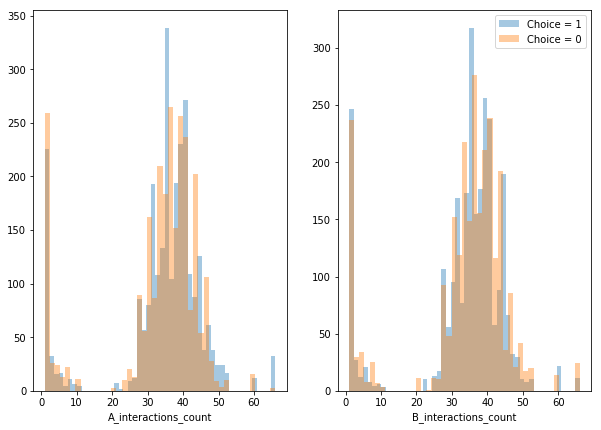

In [6]:
# Plot as a function of Choice to see the descrimination
plt.figure(figsize=(10,7))
for i,user in enumerate(['A','B'],start=1):
    feature_1 = network.loc[network['Choice'] == 1,user + '_interactions_count']
    feature_0 = network.loc[network['Choice'] == 0,user + '_interactions_count']
    plt.subplot(1, 2, i)
    sns.distplot(feature_1,kde=False)
    sns.distplot(feature_0,kde=False)
plt.legend({
            'Choice = 1':feature_1,
            'Choice = 0':feature_0
            })

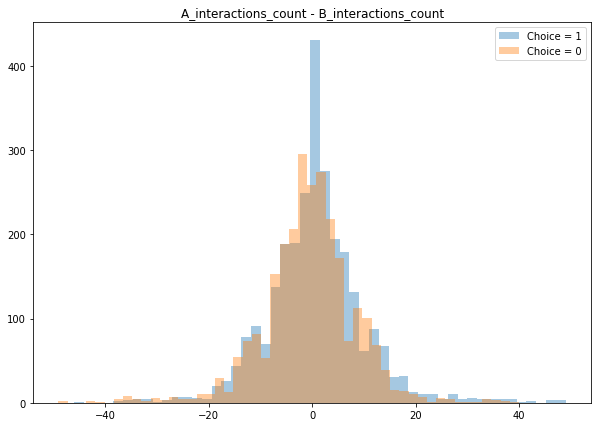

In [7]:
#And the difference
plt.figure(figsize=(10,7))
for i,user in enumerate(['A'],start=1):
    feature_1 = network.loc[network['Choice'] == 1,'A_interactions_count'] - network.loc[network['Choice'] == 1,'B_interactions_count']
    feature_0 = network.loc[network['Choice'] == 0,'A_interactions_count'] - network.loc[network['Choice'] == 0,'B_interactions_count']
    sns.distplot(feature_1,kde=False)
    sns.distplot(feature_0,kde=False)
    plt.title('A_interactions_count - B_interactions_count')
plt.legend({
            'Choice = 1':feature_1,
            'Choice = 0':feature_1,
            })

# Select a sub-network 
Easy to visualise, practise and understand different prooperties of the graph

In [8]:
query = 'A_unique_id < 8 and A_unique_id != (2,14)'#'A_unique_id < 8 and A_unique_id != (2,14)'
sub_nw = network.query(query)#query('A_unique_id < 20 and A_unique_id != (2,14,18)')
sub_nw.shape

(122, 27)

Text(0.5, 1.0, 'A_unique_id < 8 and A_unique_id != (2,14)')

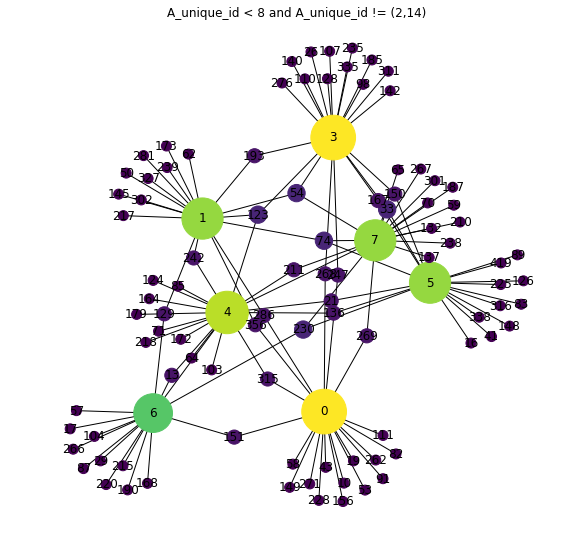

In [9]:
plt.figure(figsize=(7,7))
sub_nw_G=nx.from_pandas_edgelist(sub_nw, 'A_unique_id', 'B_unique_id',edge_attr='Choice')
degree = sub_nw_G.degree()
nx.draw(sub_nw_G,node_size=[v * 100 for v in dict(degree).values()],node_color=[20000.0 * sub_nw_G.degree(v) for v in sub_nw_G],with_labels=True)
plt.title(query)

# Study the sub-network

## General Info

In [10]:
print(nx.info(sub_nw_G))

Name: 
Type: Graph
Number of nodes: 101
Number of edges: 122
Average degree:   2.4158


## Clustering Coefficient
clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes

The **global clustering coefficient** is the number of closed triplets (or 3 x triangles) over the total number of triplets (both open and closed).

In [11]:
# return the dictionary 
cluster_coeff = nx.clustering(sub_nw_G)
# sort it 
sorted_cluster_coeff = sorted(cluster_coeff.items(),key=operator.itemgetter(1),reverse=True)
#print the avarage and top 10
print('Average cluster coeff: ',nx.average_clustering(sub_nw_G))
print('*****Top 10*****')
sorted_cluster_coeff[:10]

Average cluster coeff:  0.020098501446783334
*****Top 10*****


[(211, 1.0),
 (13, 1.0),
 (4, 0.013071895424836602),
 (6, 0.009523809523809525),
 (7, 0.007352941176470588),
 (64, 0),
 (5, 0),
 (74, 0),
 (17, 0),
 (3, 0)]

What to conclude? Larger network has to be used, otherwise it's not really clear.

## Distances 

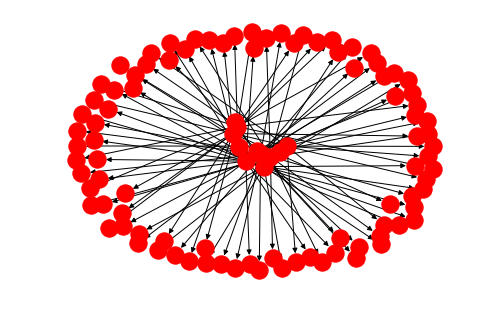

In [12]:
T = nx.bfs_tree(sub_nw_G,1)
nx.draw(T)

## Eccentricity

Eccentricity of a node A is defined as the largest distance between A and all other nodes. 

WARNING: Doesn't work for not fully connected networks

(array([ 3.,  0.,  0., 51.,  0.,  0., 24.,  0.,  0., 23.]),
 array([3. , 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 10 Patch objects>)

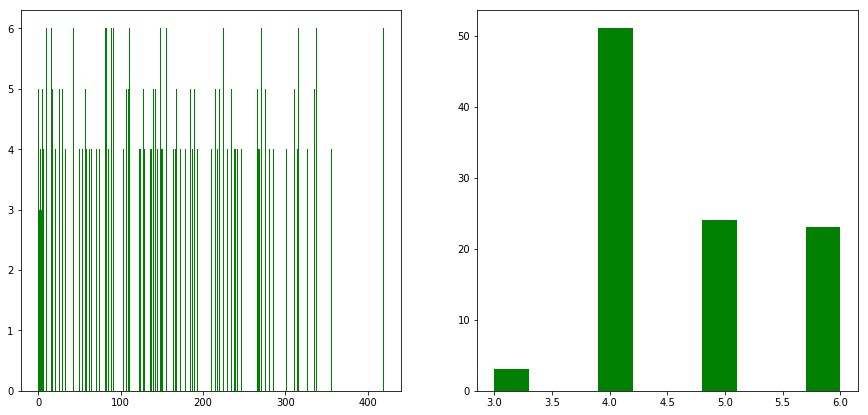

In [13]:
eccentricity = nx.eccentricity(sub_nw_G)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(list(eccentricity.keys()), list(eccentricity.values()), width= 1 , color='g')
plt.subplot(1,2,2)
plt.hist(list(eccentricity.values()), color='g')

## Degree Centrality

The degree centrality for a node v is the fraction of nodes it is connected to. Basically it's normalised number of connections (degrees)

In [14]:
degree_centrality = nx.algorithms.degree_centrality(sub_nw_G)
sorted_degree_centrality = sorted(degree_centrality.items(),key=operator.itemgetter(1),reverse=True)
sorted_degree_centrality[:10]

[(3, 0.2),
 (0, 0.2),
 (4, 0.18),
 (5, 0.17),
 (1, 0.17),
 (7, 0.17),
 (6, 0.15),
 (74, 0.03),
 (33, 0.03),
 (54, 0.03)]

## Eigenvector Centrality

It is not just how many individuals one is connected too, but the type of people one is connected with that can decide the importance of a node.

**Eigenvector centrality** (eigencentrality) is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

In [15]:
eigenvector_centrality = nx.algorithms.eigenvector_centrality(sub_nw_G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(),key=operator.itemgetter(1),reverse=True)
sorted_eigenvector_centrality[:10]

[(4, 0.3631626573005231),
 (7, 0.332102853067163),
 (3, 0.29678409798485134),
 (1, 0.2463411183872355),
 (5, 0.2407575787032778),
 (6, 0.21365275462103794),
 (0, 0.20438471861844146),
 (123, 0.16612140588566482),
 (54, 0.16042846305496963),
 (33, 0.15940426668503413)]

## Betweenness Centrality 
### Nodes
The Betweenness Centrality is the centrality of control. It represents the frequency at which a point occurs on the geodesic (shortest paths) that connected pair of points. It quantifies how many times a particular node comes in the shortest chosen path between two other nodes. The nodes with high betweenness centrality play a significant role in the communication/information flow within the network. The nodes with high betweenness centrality can have a strategic control and influence on others.

**Betweenness centrality** quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. I

In [16]:
betweenness_centrality = nx.algorithms.betweenness_centrality(sub_nw_G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(),key=operator.itemgetter(1),reverse=True)
sorted_betweenness_centrality[:10]

[(4, 0.2909591951258617),
 (3, 0.2859379072106344),
 (0, 0.279090712317985),
 (7, 0.23852136808197416),
 (1, 0.22763226784438903),
 (5, 0.21824912180972783),
 (6, 0.2152367324033991),
 (123, 0.09641936682845773),
 (74, 0.066828202661536),
 (230, 0.06618847202180535)]

### Edges

Used as a process of edge removal. Start with graph all its edges; then remove edges with the highest betweenness, until the graph has broken into a suitable number of connected components

In [17]:
edge_betweenness_centrality = nx.algorithms.edge_betweenness_centrality(sub_nw_G)
sorted_edge_betweenness_centrality = sorted(edge_betweenness_centrality.items(),key=operator.itemgetter(1),reverse=True)
sorted_edge_betweenness_centrality[:10]

[((4, 123), 0.08977180575200382),
 ((4, 6), 0.08630795222379384),
 ((3, 123), 0.08511308988041658),
 ((4, 7), 0.06294161559013045),
 ((74, 1), 0.05977989227494178),
 ((7, 269), 0.058810088151672324),
 ((4, 315), 0.05880810938236681),
 ((6, 230), 0.05841371994342291),
 ((5, 74), 0.05477051276556226),
 ((6, 151), 0.054549504950495036)]

One can divide the network into communities using some criteria on the betweenness, e.g. divide until the relaive difference is more than x%

# Network communities

## Independent networks
Check the number of "independent", i.e. not connected between each other, sub-networks. To be studied with a full network

In [18]:
connected_components = nx.connected_components(G)
print(len(list(connected_components)))

316


## Partition

### Partition with Louvain algorithm

Implemented as described in: https://arxiv.org/abs/0803.0476

Implementation: https://python-louvain.readthedocs.io/en/latest/api.html

In [19]:
partition = community.best_partition(sub_nw_G)
values = [partition.get(node) for node in sub_nw_G.nodes()]
#Create network layout for visualizations
spring_pos = nx.spring_layout(sub_nw_G)

In [20]:
# Make a dictionary with different communities
community_notes = defaultdict(list)
{val : community_notes[val].append(key) for key, val in partition.items()}
print('Number of the communities: ',len(community_notes))

Number of the communities:  7


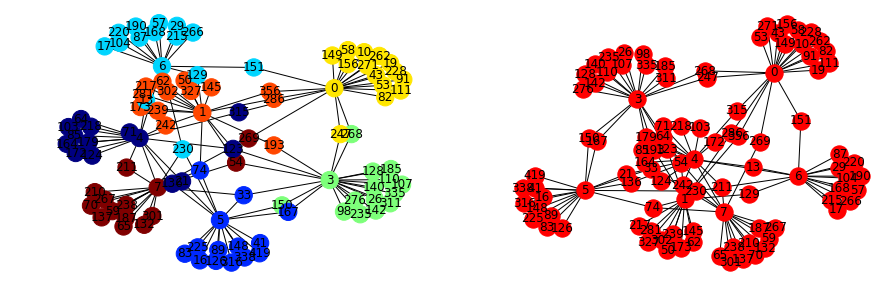

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axis("off")
nx.draw_networkx(sub_nw_G, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, with_labels = True)
plt.subplot(1,2,2)
nx.draw(sub_nw_G, with_labels = True)

* One can nicely see the partition of the selected sub-network. 
* Division seems to be reasonable. 
* Selection of the nodes in the middle might be questioned, maybe one can come up with a more sophisticated clustering algorithm 

### Partitions via Girvan-Newman (betweenness)

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram

In [22]:
iterator_GN = nx.algorithms.community.centrality.girvan_newman(sub_nw_G)
partition_GN = [x for x in next(iterator_GN)]

Different methods of community detection are implemented in networkx: https://networkx.github.io/documentation/stable/reference/algorithms/community.html
also, many more exist: 
* https://arxiv.org/pdf/physics/0605087.pdf
* https://link.springer.com/article/10.1140/epjb/e2004-00125-x
* https://arxiv.org/abs/cond-mat/0408187

# Full network

Get back to the full network. Partition it and study the communities

**Use Louvain algorithm**

In [23]:
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

In [24]:
# Make a dictionary with different communities
community_notes = defaultdict(list)
{val : community_notes[val].append(key) for key, val in partition.items()}
print('Number of the communities: ',len(community_notes))

Number of the communities:  330


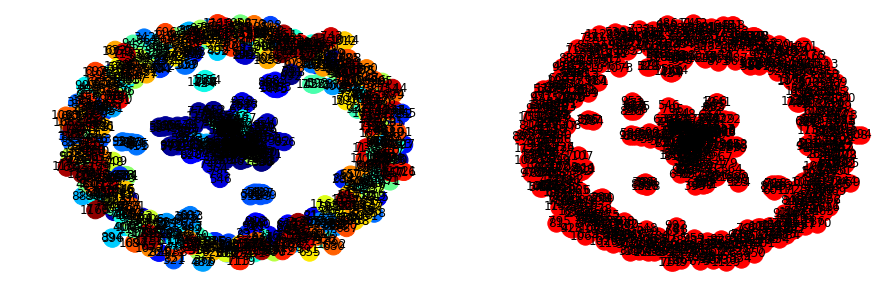

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, with_labels = True)
plt.subplot(1,2,2)
nx.draw(G, with_labels = True)

## Study properties of communities

In [26]:
# Add community column
for user in ['A','B']:
    network[user + '_community'] = network[user + '_unique_id']
    network[user + '_community'] = network[user + '_community'].apply(lambda x : partition[x])

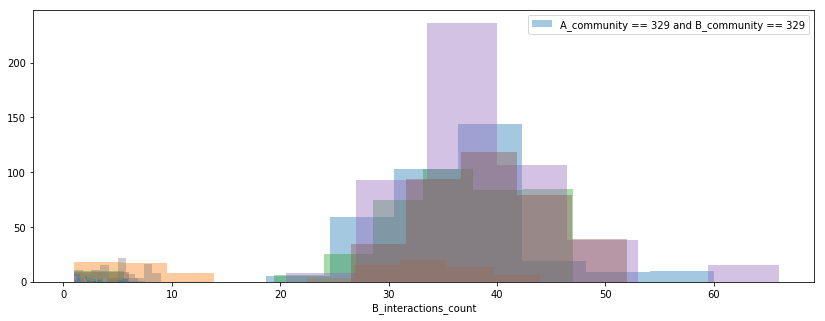

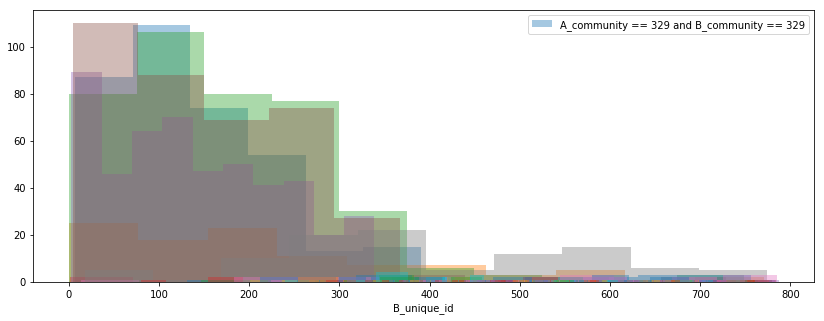

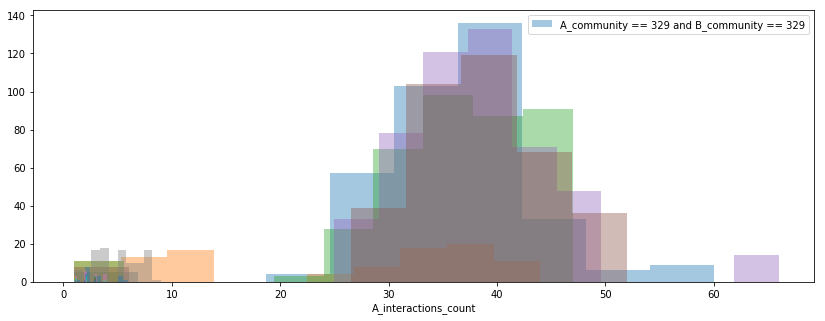

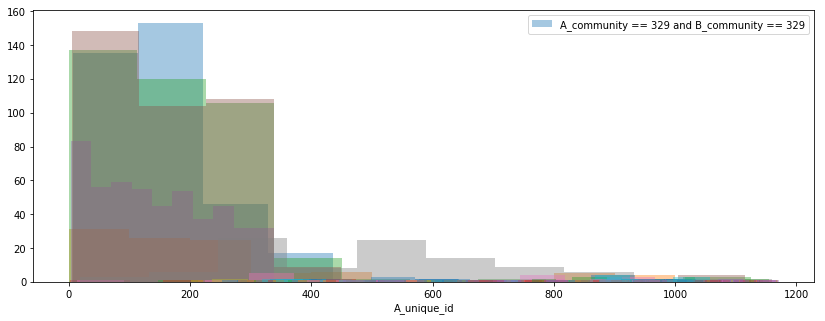

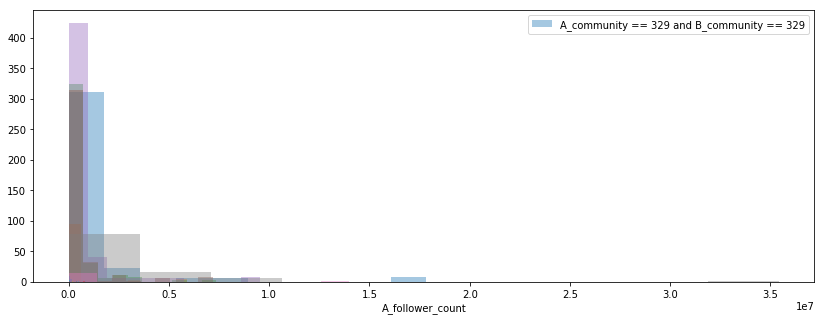

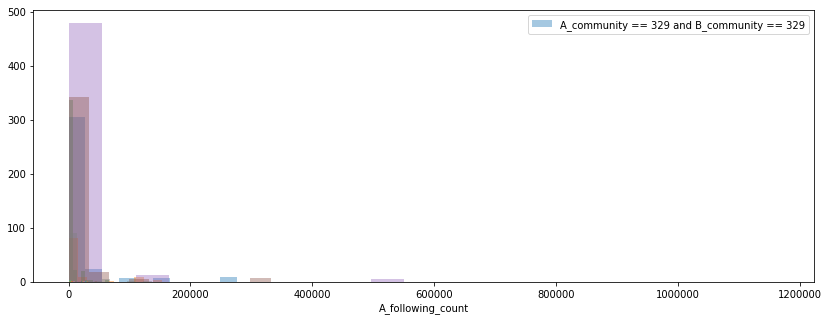

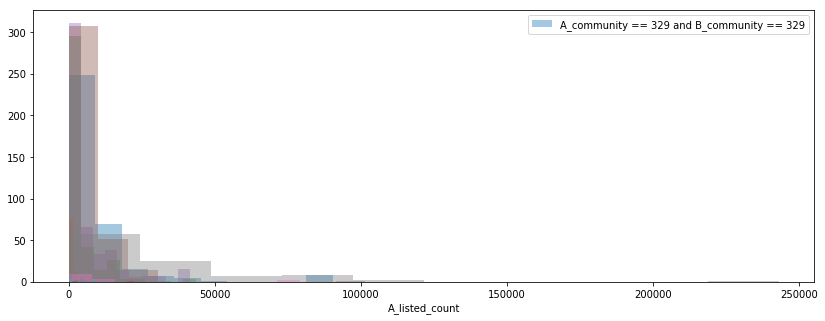

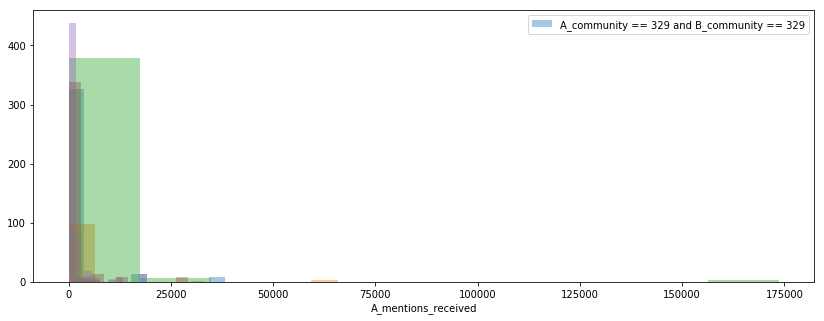

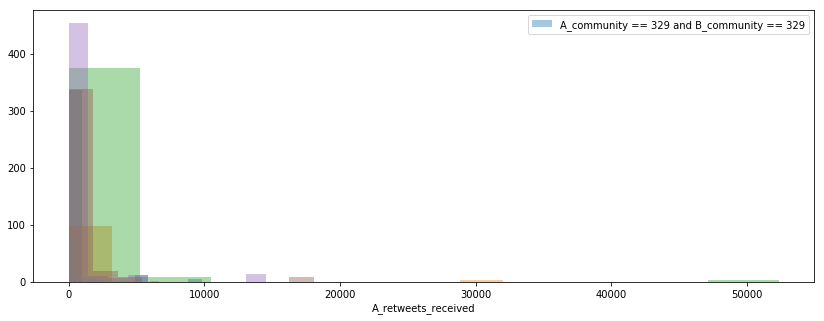

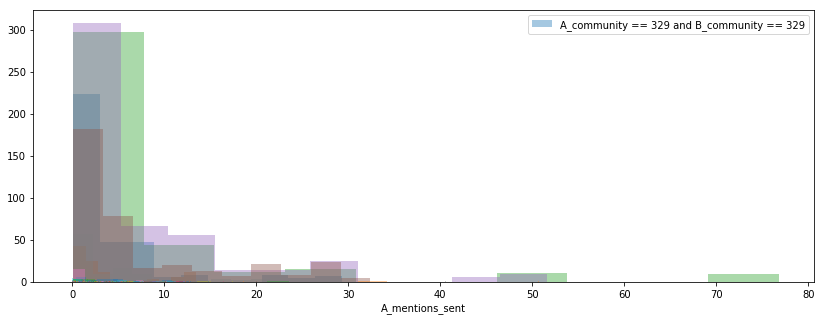

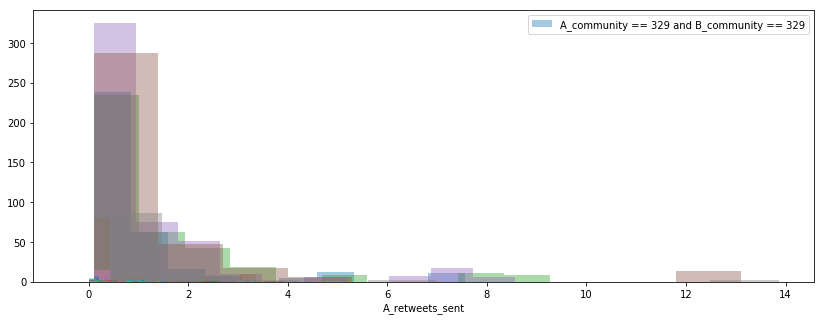

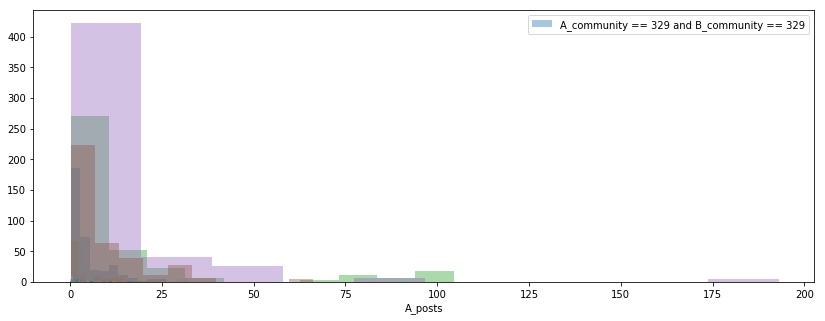

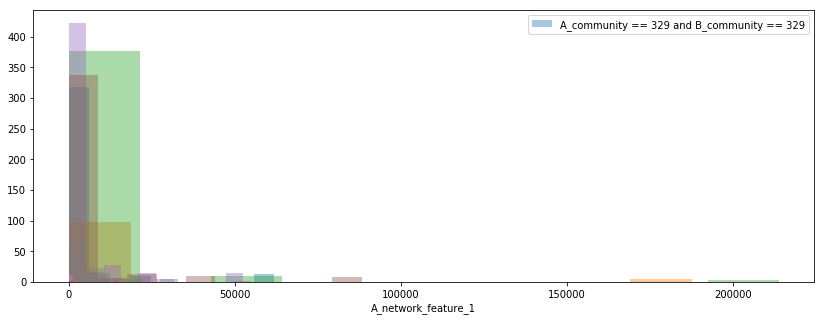

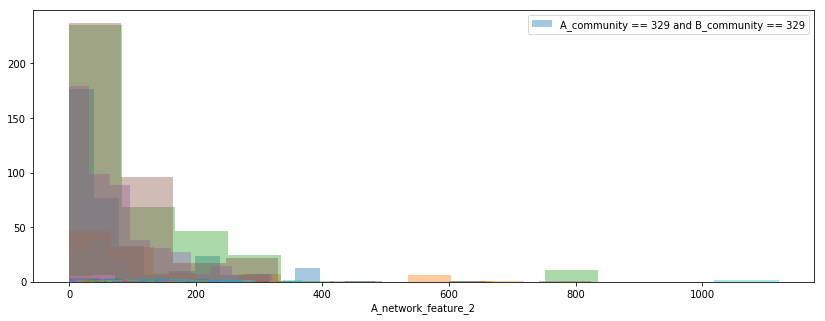

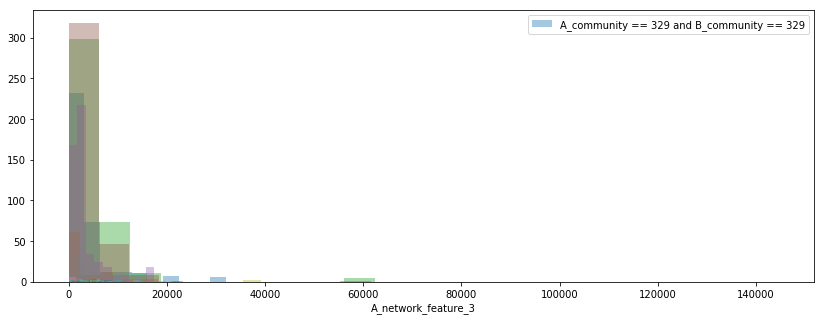

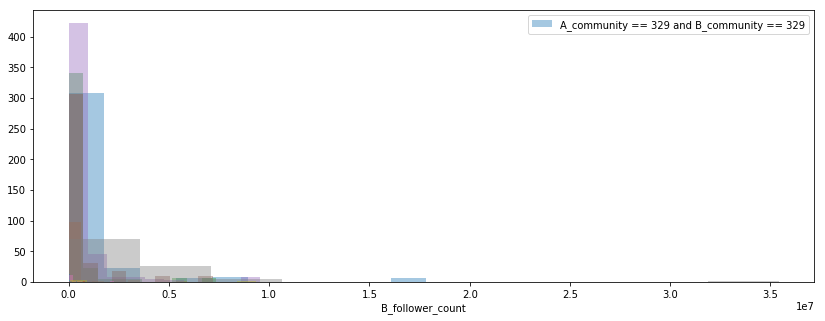

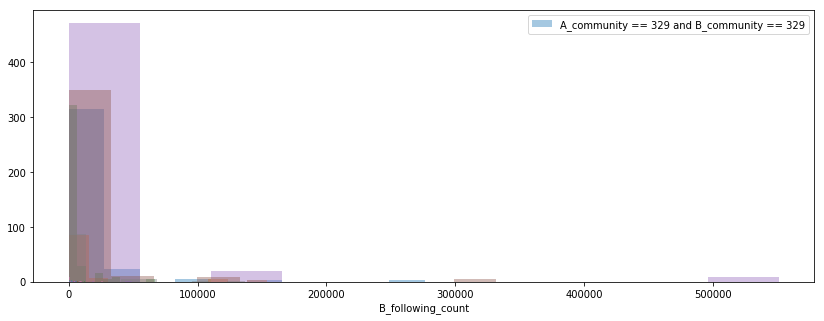

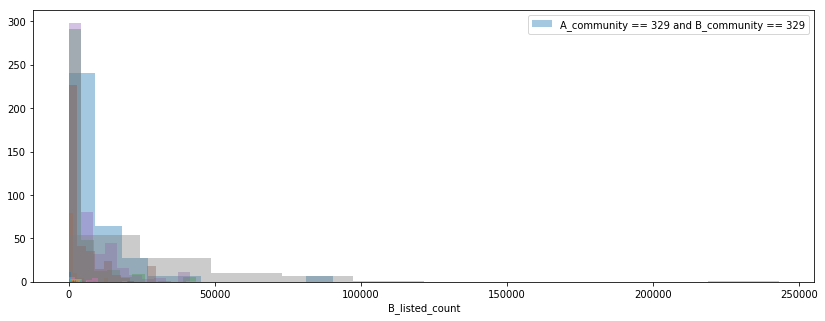

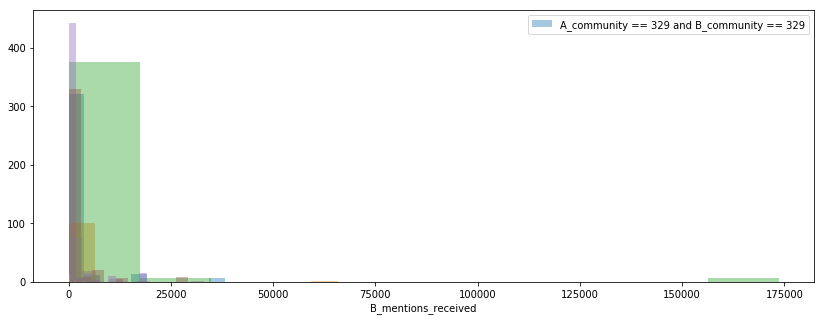

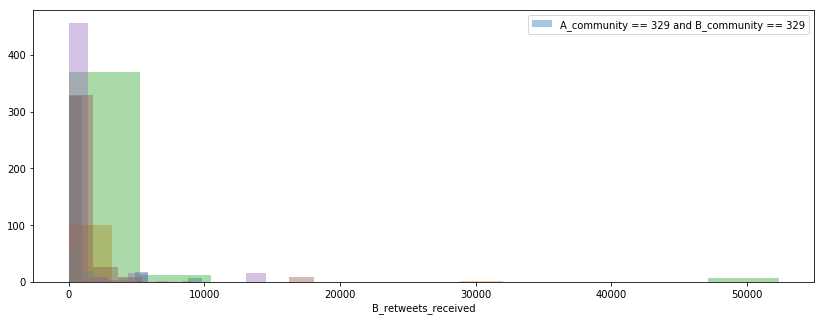

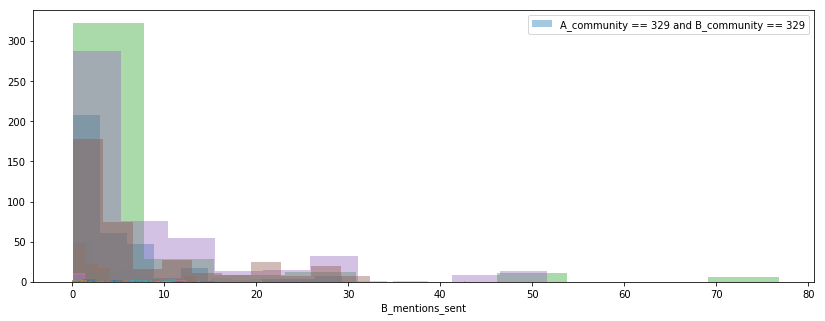

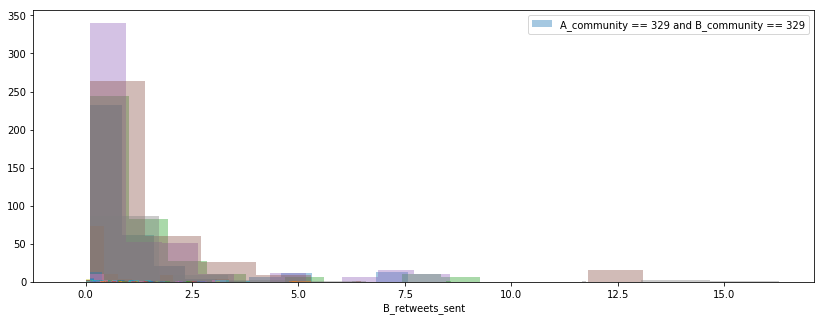

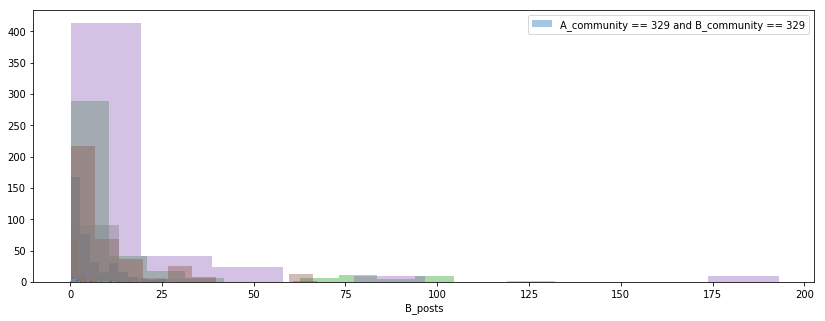

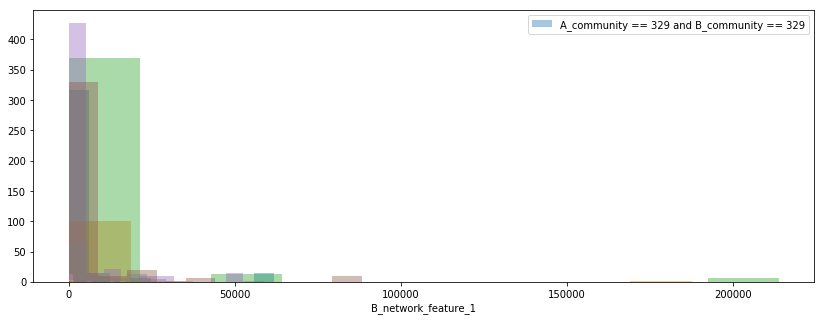

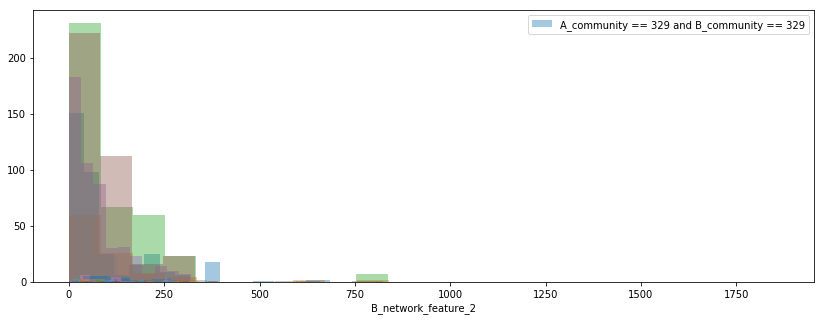

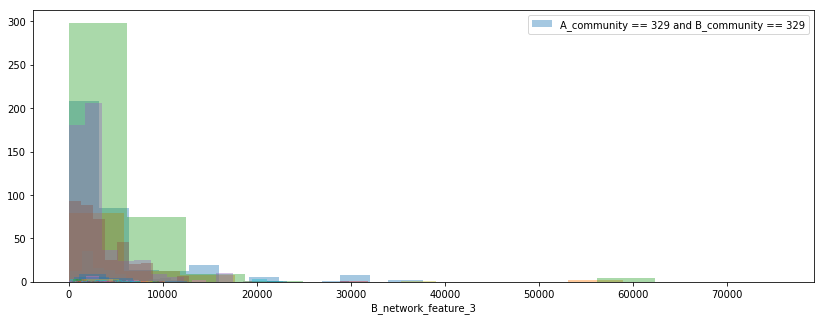

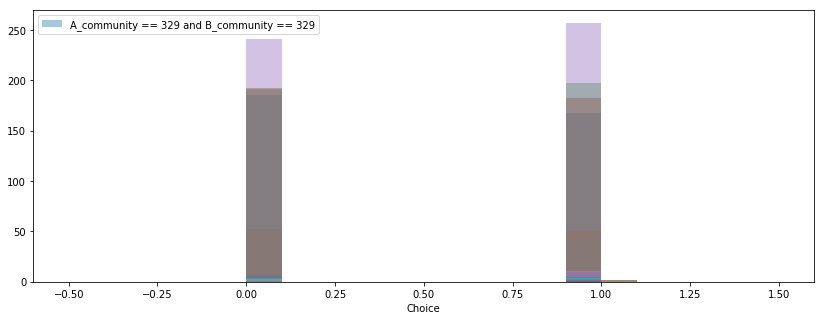

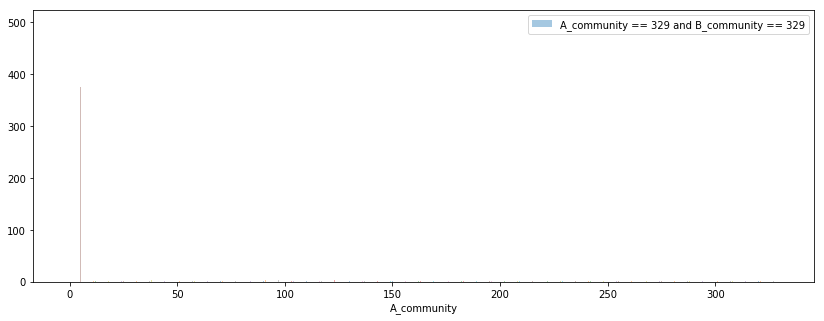

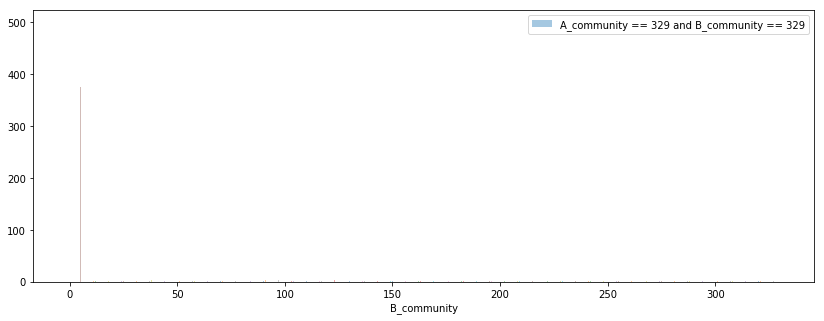

In [27]:
# Plot the features 
for i, col in enumerate(network.columns,start=0):
    plt.figure(i+1,figsize=(14, 5))
    for com in community_notes.keys():
        query = 'A_community == ' + str(com) + ' and B_community == ' + str(com)
        feature = network.query(query)[col]
    

        # distribution of each feature
        sns.distplot(feature,kde=False,bins=10)
        plt.legend({
                    query:feature,
                   })

In [28]:
d_community_interactions = dict()
# Count number of 1 and 0 in each category
for com in community_notes.keys():
    query = 'A_community == ' + str(com) + ' and B_community == ' + str(com)
    vals = network.query(query)['Choice'].value_counts().values
    if(len(vals)>1):
        # number of total interactions inside the community
        interactions = (vals[1] + vals[0])
        d_community_interactions[com] = [interactions,0]
        print('Cummunity {}, Number of "0" and "1": {}, Total #interactions = {} +/- {}'.format(com,vals,interactions,0))
    else:
        d_community_interactions[com] = [vals[0],0]
        print('Cummunity {}, Number of "0" and "1": {}, Total #interactions = {}'.format(com,vals,vals[0]))

Cummunity 0, Number of "0" and "1": [185 168], Total #interactions = 353 +/- 0
Cummunity 1, Number of "0" and "1": [52 50], Total #interactions = 102 +/- 0
Cummunity 2, Number of "0" and "1": [197 191], Total #interactions = 388 +/- 0
Cummunity 3, Number of "0" and "1": [3], Total #interactions = 3
Cummunity 4, Number of "0" and "1": [257 241], Total #interactions = 498 +/- 0
Cummunity 5, Number of "0" and "1": [192 182], Total #interactions = 374 +/- 0
Cummunity 6, Number of "0" and "1": [2], Total #interactions = 2
Cummunity 7, Number of "0" and "1": [58 43], Total #interactions = 101 +/- 0
Cummunity 8, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 9, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 10, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 11, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 12, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 13, Number of "0" and "1": [1 1], Total #interactions = 2 +/- 

Cummunity 132, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 133, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 134, Number of "0" and "1": [1 1], Total #interactions = 2 +/- 0
Cummunity 135, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 136, Number of "0" and "1": [2], Total #interactions = 2
Cummunity 137, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 138, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 139, Number of "0" and "1": [4 1], Total #interactions = 5 +/- 0
Cummunity 140, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 141, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 142, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 143, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 144, Number of "0" and "1": [2 1], Total #interactions = 3 +/- 0
Cummunity 145, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 146, Number of "0" and "1": 

Cummunity 283, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 284, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 285, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 286, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 287, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 288, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 289, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 290, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 291, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 292, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 293, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 294, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 295, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 296, Number of "0" and "1": [1], Total #interactions = 1
Cummunity 297, Number of "0" and "1": [1], Total #interactions

0 353 [190, 280, 54, 7, 8, 195, 179, 12, 118, 140, 210, 84, 338, 188, 30, 34, 126, 105, 139, 42, 46, 48, 59, 62, 368, 63, 66, 218, 141, 70, 71, 78, 263, 82, 120, 83, 85, 114, 92, 132, 252, 124, 133, 137, 166, 158, 235, 199, 177, 251, 243, 207, 234, 296, 340, 299, 860, 646, 1080]
1 102 [0, 245, 23, 65, 52, 53, 233, 97, 67, 68, 86, 202, 108, 281, 116, 318, 151, 156, 805, 165, 325, 175, 192, 205, 270, 504, 840, 447, 848, 871, 357, 890, 391, 409, 937, 455, 478, 499, 976, 988, 1000, 543, 557, 566, 572, 667, 735, 771]
2 388 [113, 1, 10, 11, 15, 327, 16, 77, 111, 21, 262, 193, 242, 24, 27, 100, 28, 41, 211, 47, 143, 51, 61, 222, 107, 79, 89, 180, 239, 127, 267, 135, 232, 272, 145, 149, 150, 395, 157, 160, 162, 171, 276, 293, 187, 303, 189, 191, 36, 196, 328, 208, 812, 236, 244, 257, 302, 315, 380, 662, 903, 938, 489, 461, 723, 749, 520, 539, 583, 1055, 1077, 1125, 739]
4 498 [99, 3, 307, 4, 6, 123, 9, 286, 13, 17, 185, 22, 25, 29, 32, 225, 33, 93, 39, 266, 44, 45, 110, 50, 167, 128, 60, 64, 2

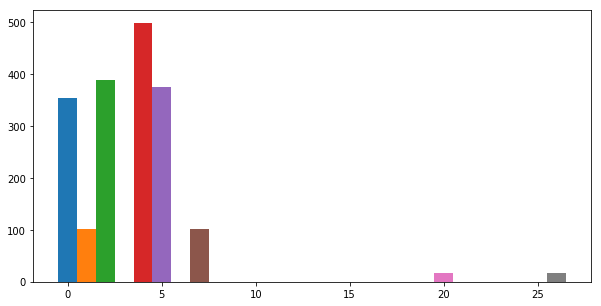

In [29]:
# Visualise with bars
plt.figure(figsize=(10,5))
for com in community_notes.keys():
    if d_community_interactions[com][0] > 10:
        ax = plt.bar(x=com,width=1,height=d_community_interactions[com][0],yerr=d_community_interactions[com][1])
        print(com,d_community_interactions[com][0],community_notes[com])

Intermidiate conclusion:

* during the study of the full network it was found that there are only 5-6 very large communities and 3 more with number of people more than 10. Other communities are either 1 to 1 interaction (couples) or small communities with 2-4 people inside (a family).
* Thus, it does make sense to study separately large communities: 0/1/2/4/5/7, communities of a middle to small size and 1 to 1 cases.

### Visualising communities

In [43]:
def visualise_communities(comms,c_network):
    comms_size = len(comms)
    plt.figure(figsize=(20,8))
    for i,com in enumerate(comms,start=1):
        plt.subplot(1,comms_size,i)
        sub_nw_commi = nx.from_pandas_edgelist(c_network.query('A_community == ' + str(com) + ' and B_community == ' + str(com)), 'A_unique_id', 'B_unique_id')
        degree = sub_nw_commi.degree()
        nx.draw(sub_nw_commi,node_size=[v * 100 for v in dict(degree).values()],node_color=[20000.0 * sub_nw_commi.degree(v) for v in sub_nw_commi],with_labels=True)

#### Large communities

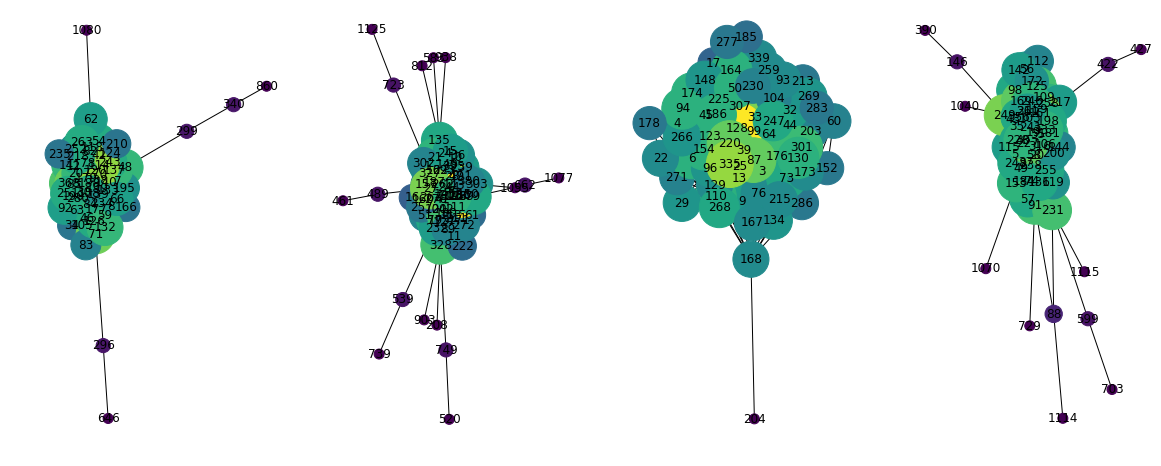

In [44]:
# Largest communitites
visualise_communities([0,2,4,5],network)

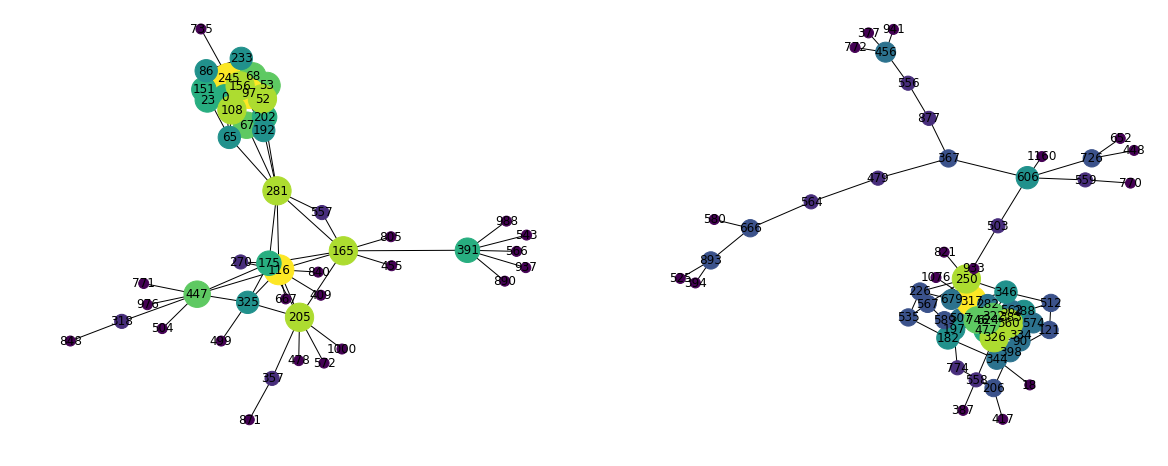

In [45]:
# Not as large, but still significant
visualise_communities([1,7],network)

#### Chains

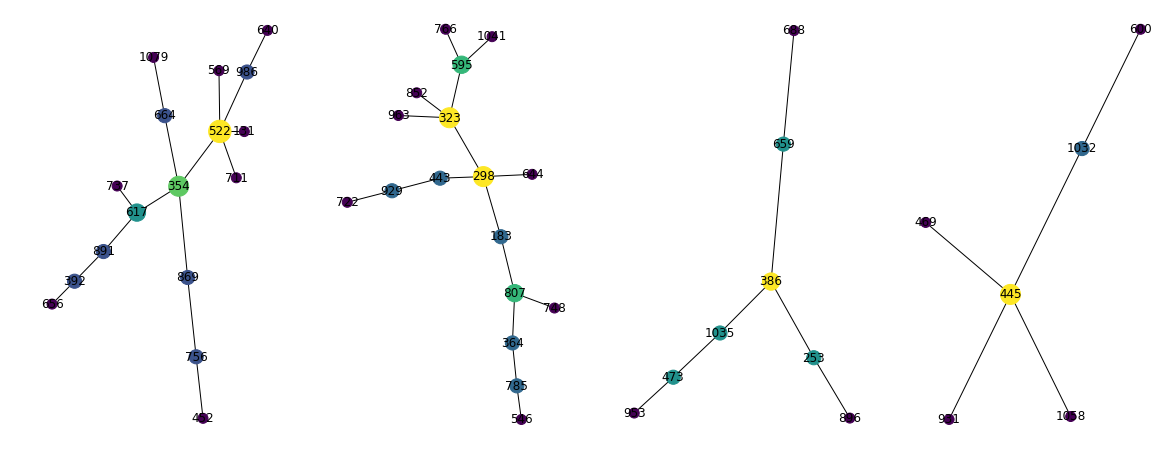

In [46]:
# To cross-check, visualise mid communities:
visualise_communities([20,26,40,139],network)

# Network partition

In [47]:
# Function to perform partition of the network
def network_partition(network,d_community_interactions,size_large,size_medium):
    '''
    size_large - minimum number of interactions within the community to count it as large
    size_meduium - minimum number of interactions within the community to count it as medium
    chains - counted where number of interactions is > 1 but < size_meduium
    couples - size of interactions = 1 
    '''
    c_network = network.copy()
    c_network['A_L_community'] = 10
    comms = defaultdict(list)
    for com,number in d_community_interactions.items():
        #large comunities
        if number[0] >= size_large:
            comms['L'].append(com)
        #medium size communities:
        elif number[0] >= size_medium:
            comms['M'].append(com) 
        # small size
        elif number[0] > 1:
            comms['S'].append(com)
        # couples
        else: 
            comms['XS'].append(com)
    
    # Create the columns
    for user in ['A','B']: 
        for com in comms.keys():
            c_network[user + '_' + com +'_community'] = c_network[user + '_community'].apply(lambda x : 1 if x in comms[com] else 0)
    return c_network

In [48]:
partitioned_nw = network_partition(network,d_community_interactions,200,50)
partitioned_nw.head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
0,34,0,40,190,228,302,3,0.583979,0.100503,0.100503,...,0,1,1,0,0,0,0,1,0,0
1,33,1,39,113,21591,1179,228,90.456506,25.798292,5.709329,...,2,2,1,0,0,0,1,0,0,0
2,3,2,1,788,7310,1215,101,25.503644,9.556347,5.361519,...,3,3,0,0,1,0,0,0,1,0
3,39,3,38,99,20,7,2,7.690824,0.277306,1.331508,...,4,4,1,0,0,0,1,0,0,0
4,37,4,42,307,45589,862,2641,148.854279,36.998884,27.881768,...,4,4,1,0,0,0,1,0,0,0


## Visualise the partitioned networks

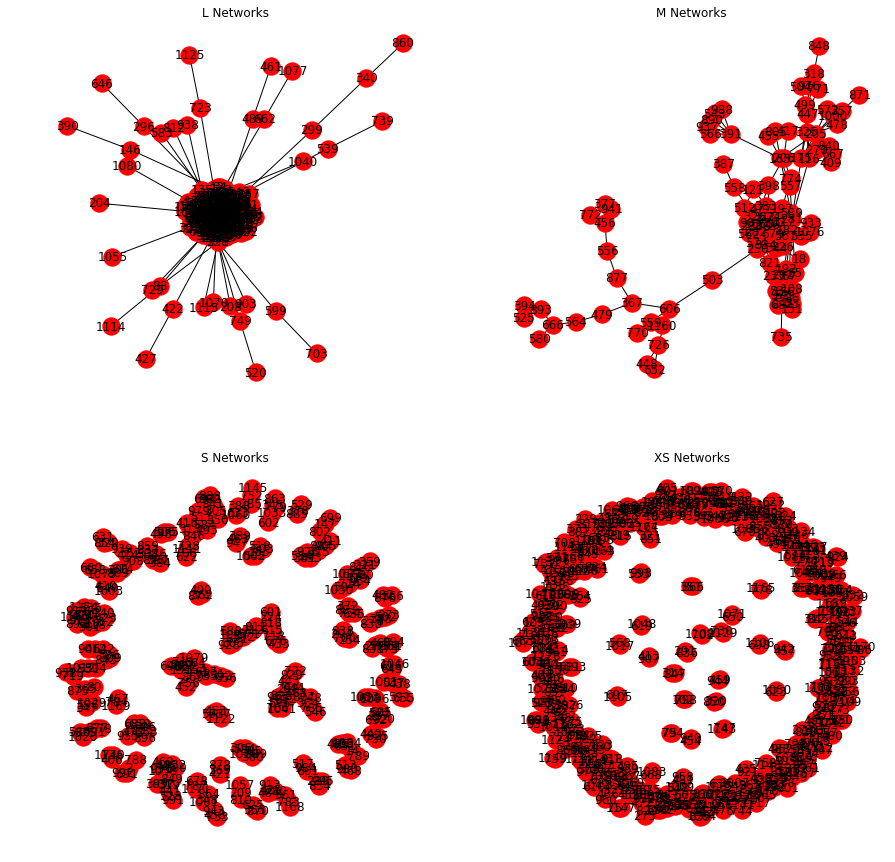

In [49]:
# Build the graph for all points
plt.figure(figsize=(15,15))
for i,s in enumerate(['L','M','S','XS'],start=1):
    plt.subplot(2, 2, i)
    partitioned_nw_G=nx.from_pandas_edgelist(partitioned_nw.query('A_' + s + '_community == 1 and B_' + s + '_community == 1'), 'A_unique_id', 'B_unique_id')
    nx.draw(partitioned_nw_G,with_labels=True)
    plt.title(s + ' Networks')

* Maybe XS and S can be merged for simplicity

## Check the distributions

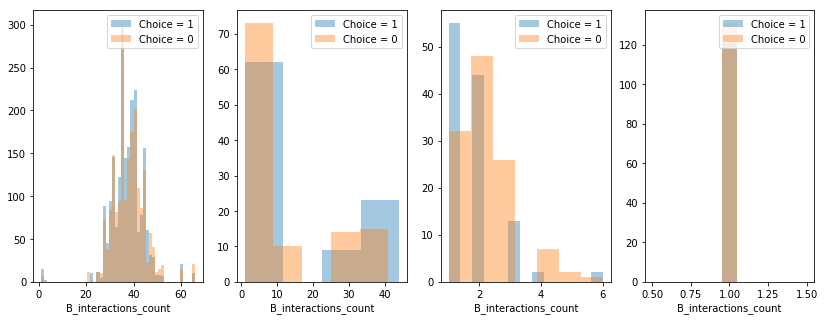

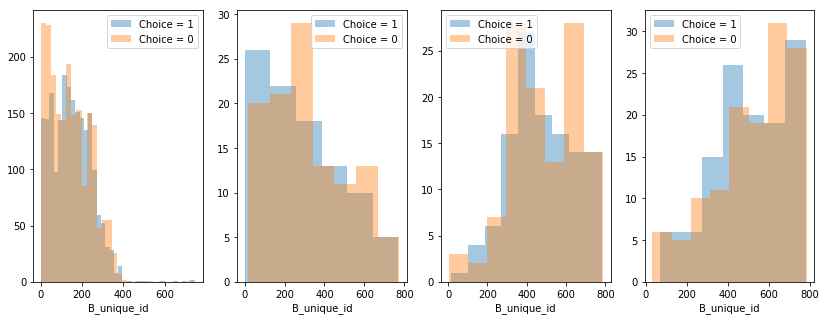

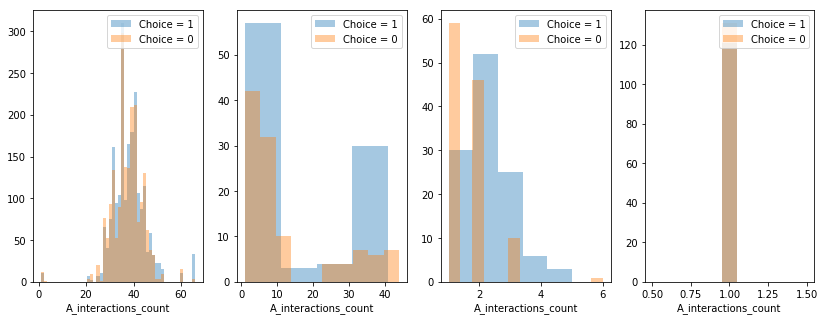

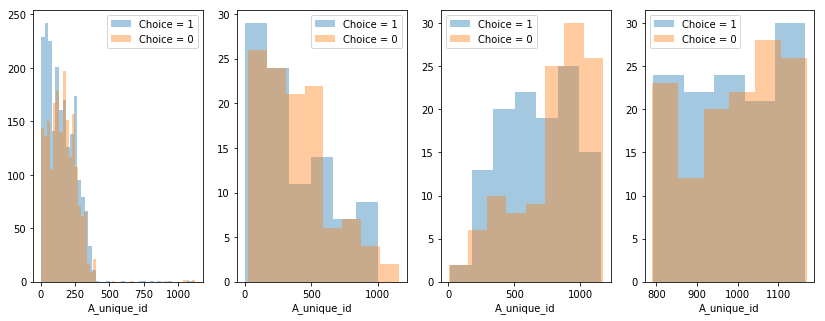

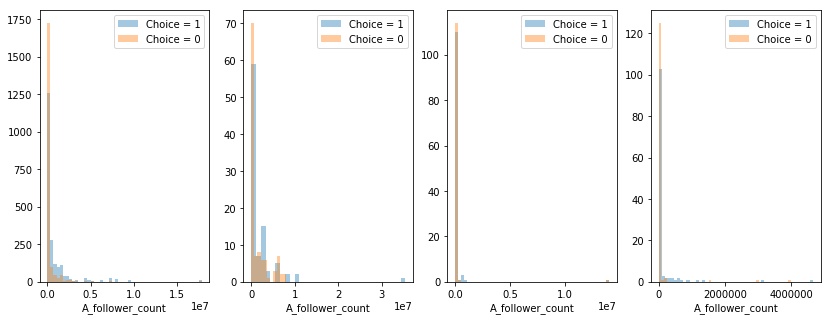

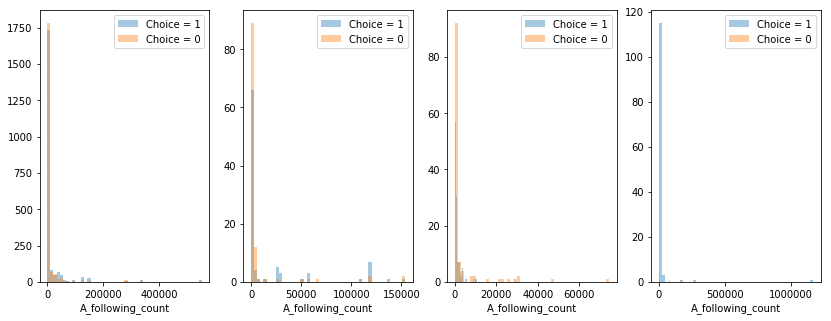

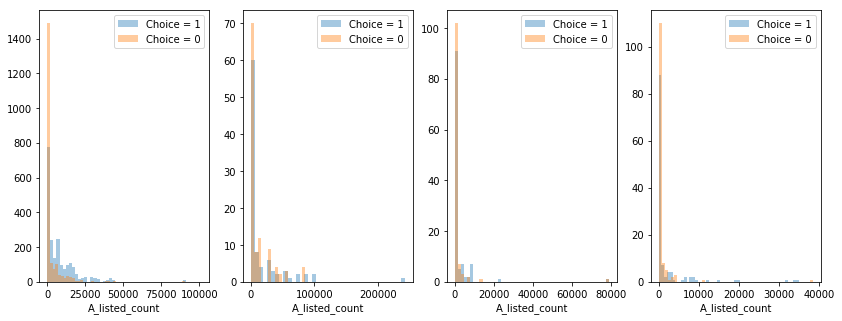

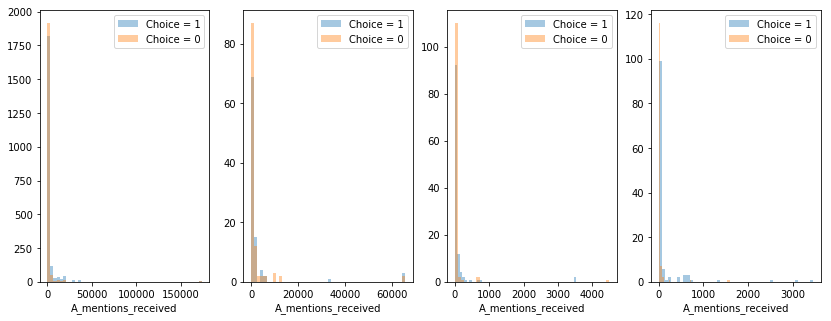

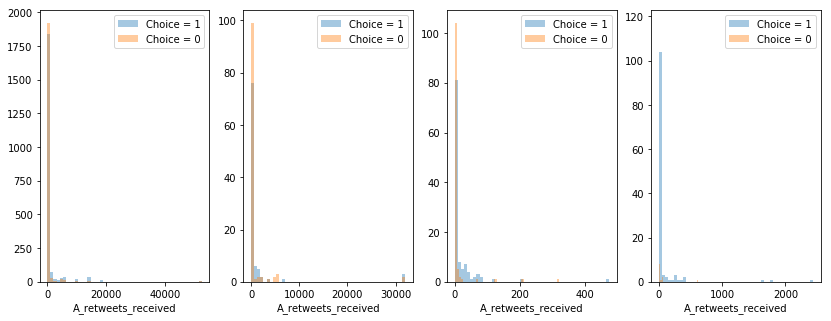

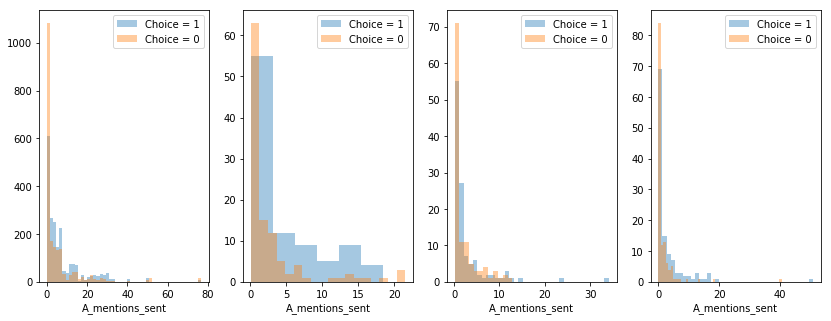

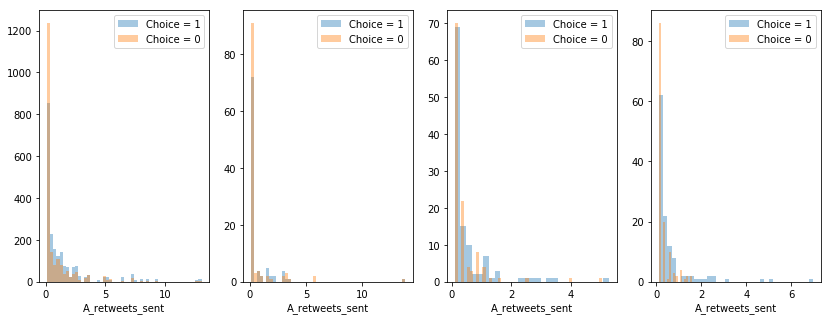

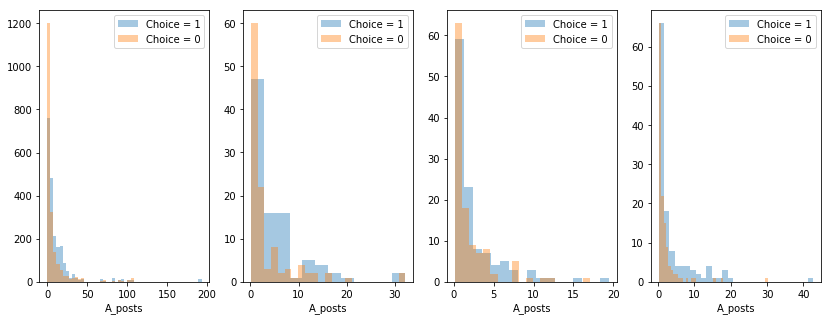

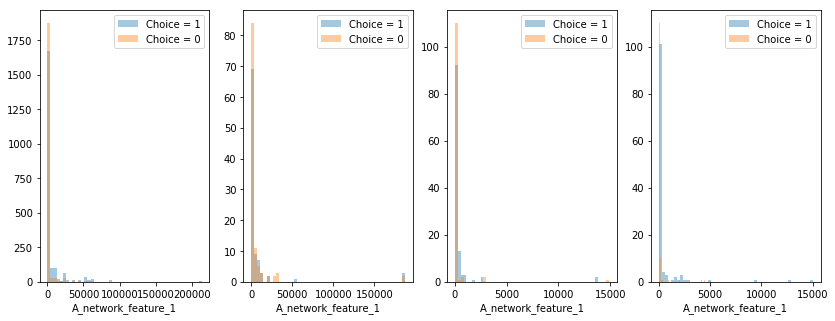

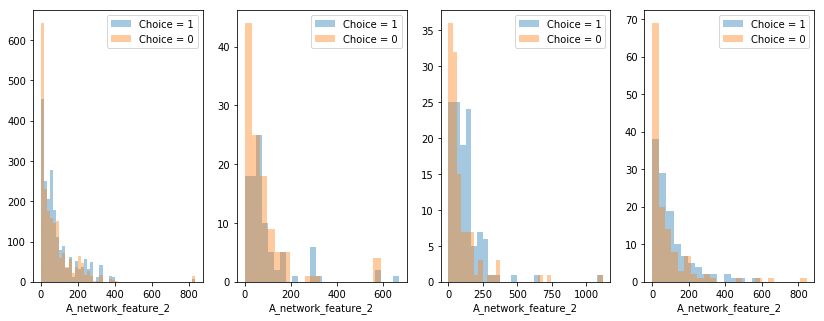

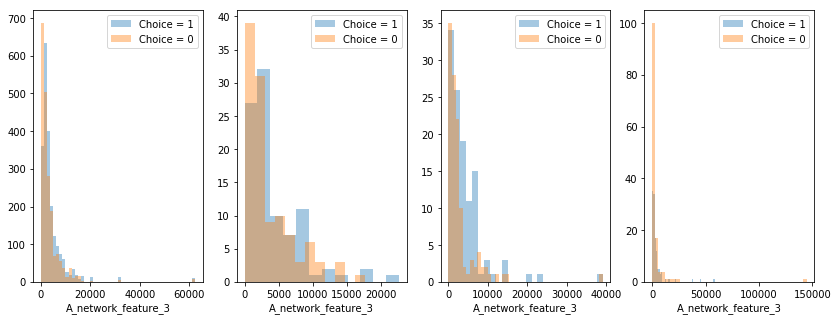

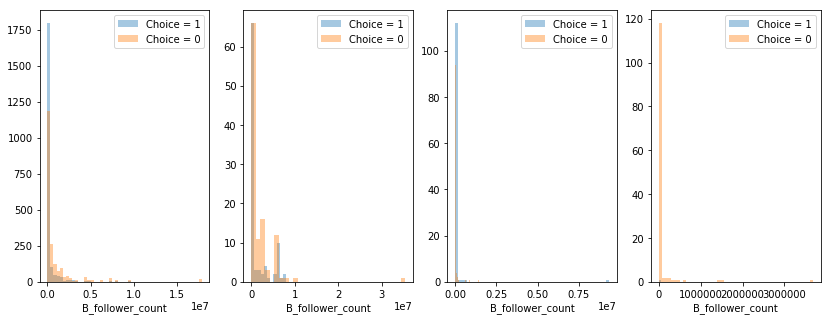

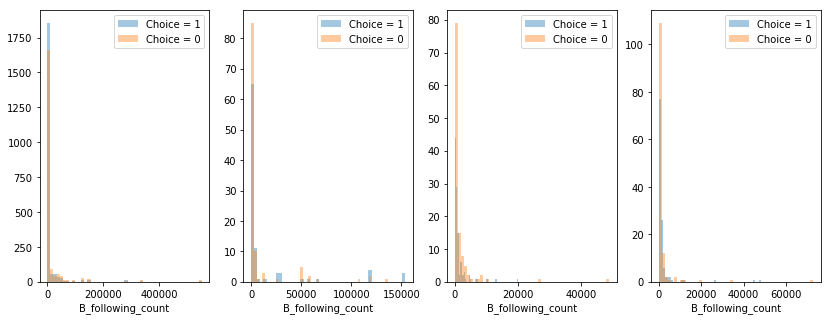

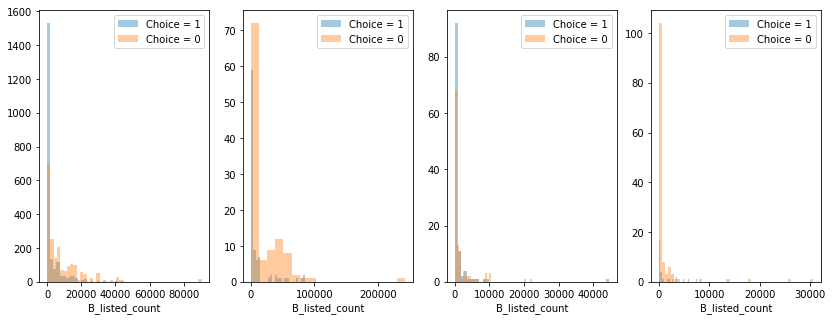

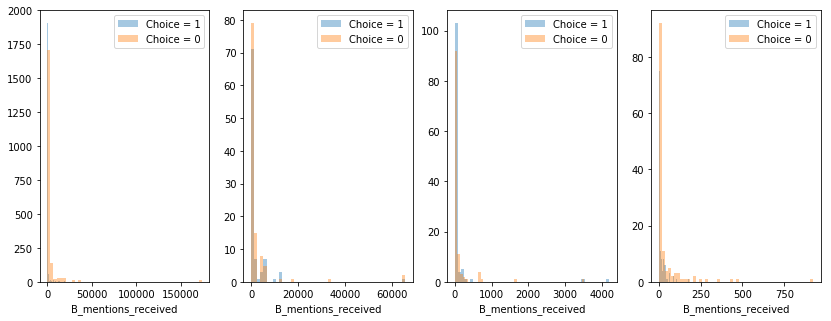

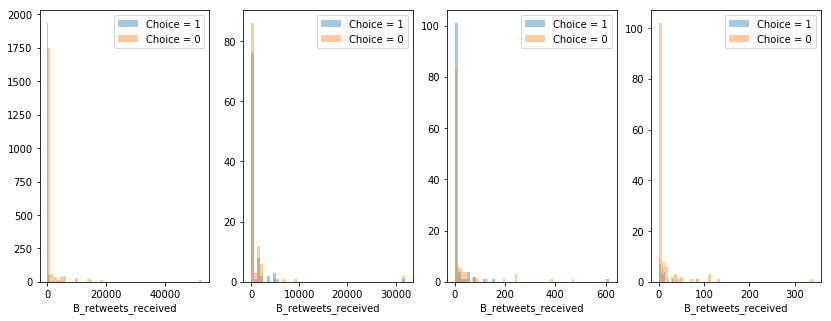

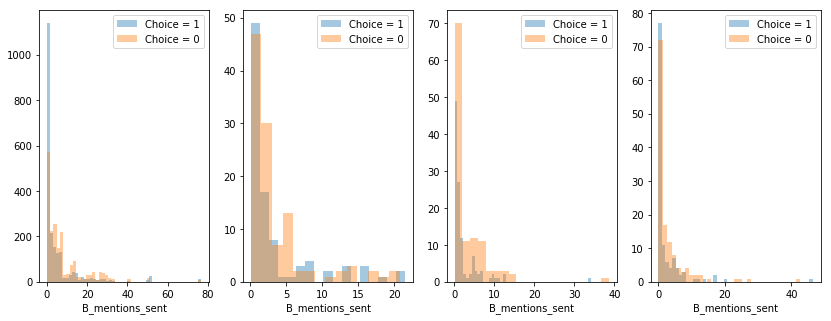

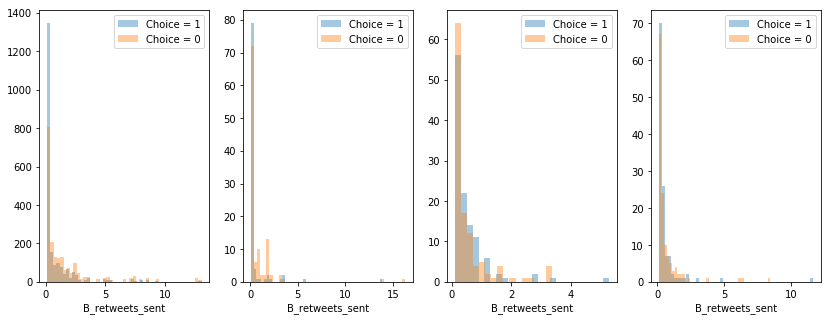

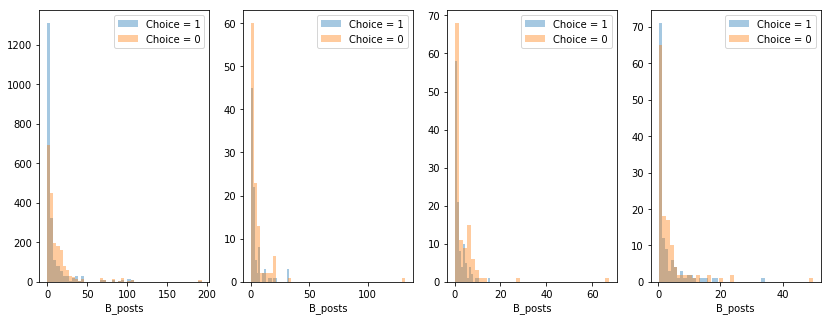

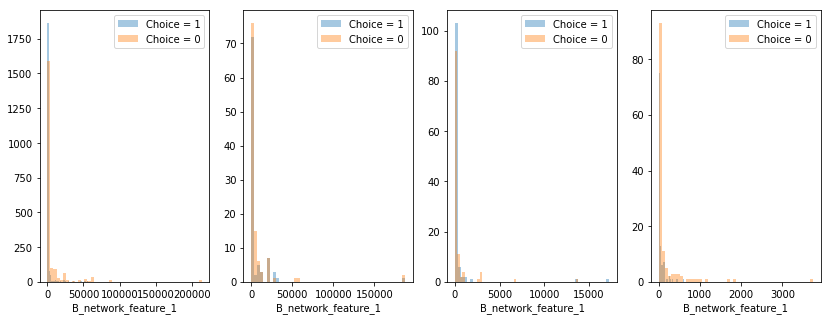

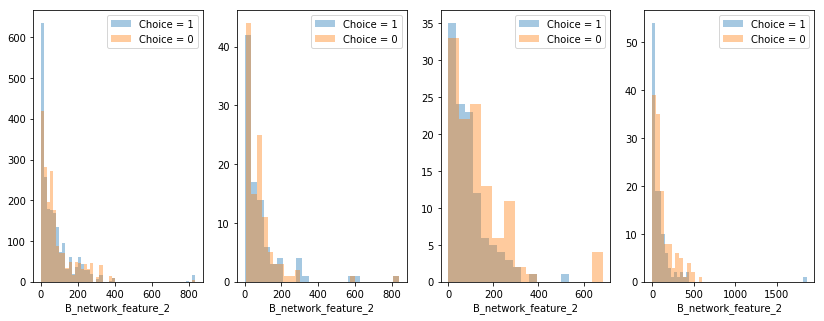

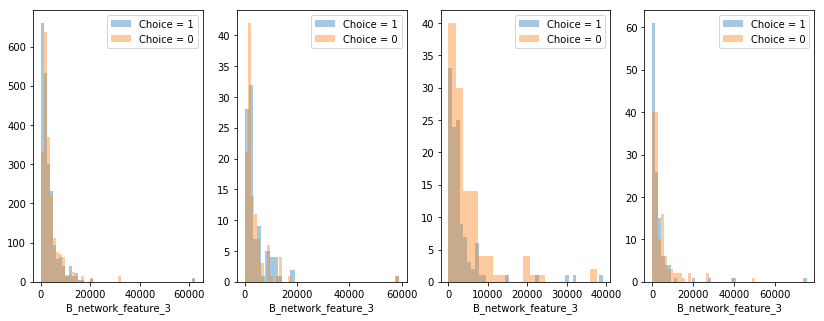

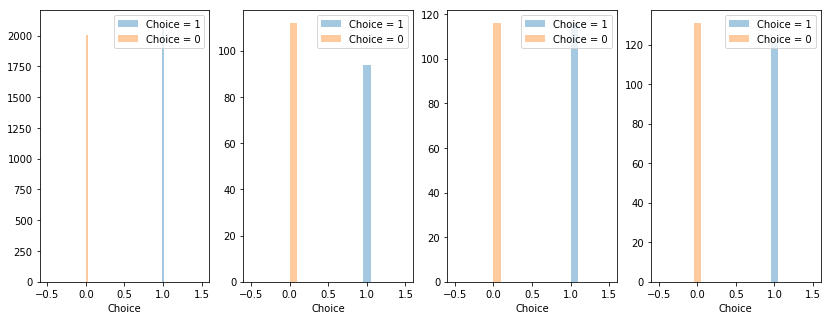

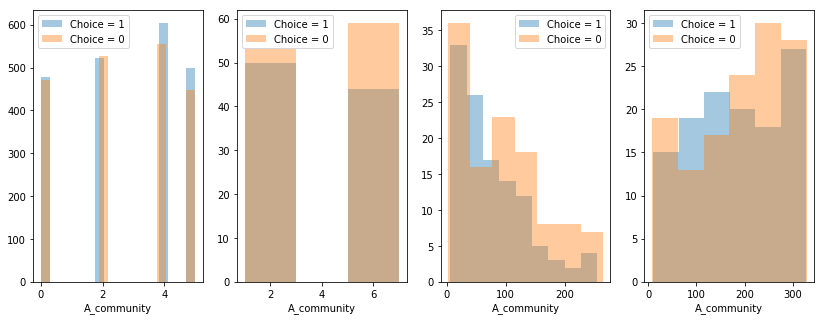

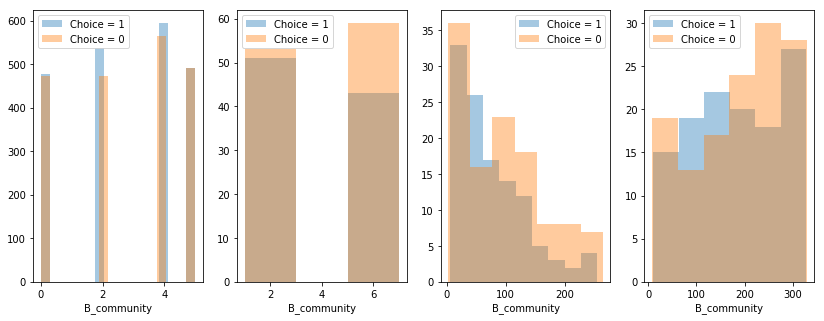

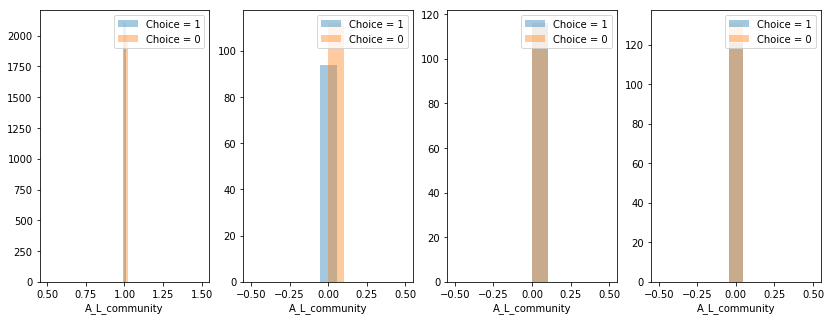

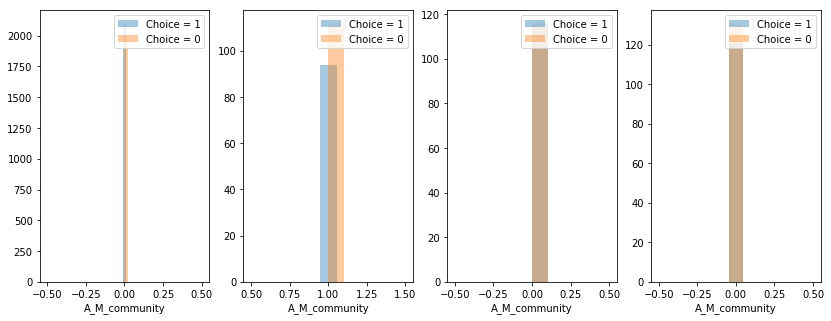

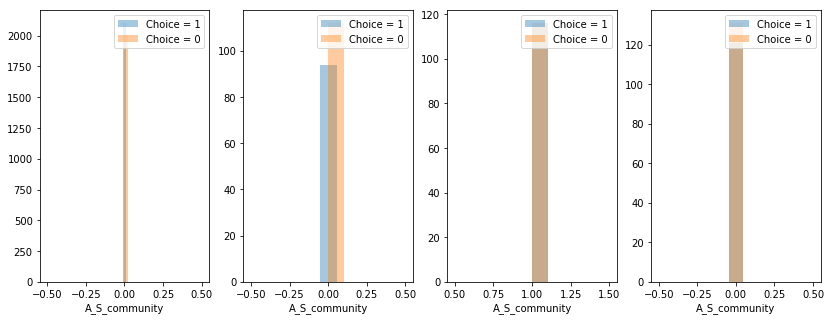

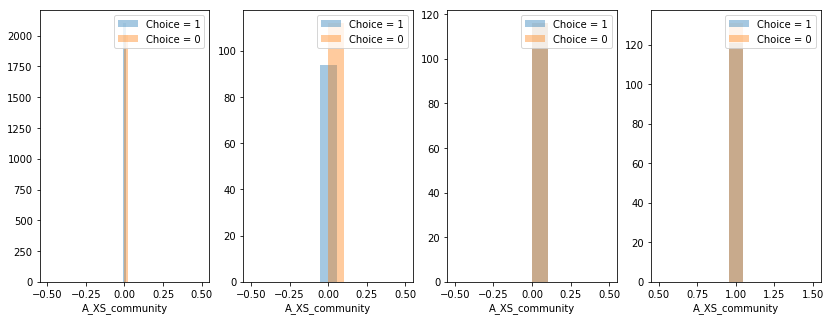

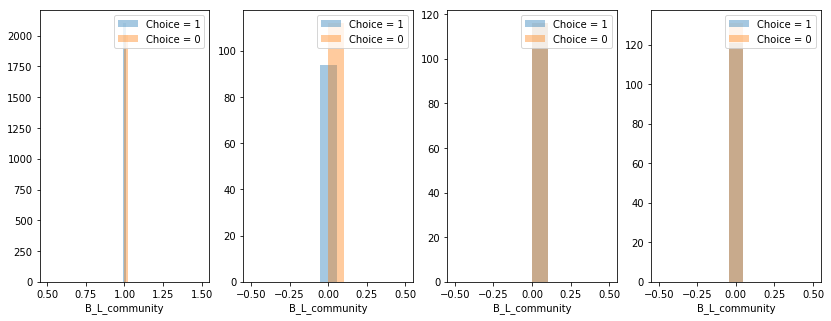

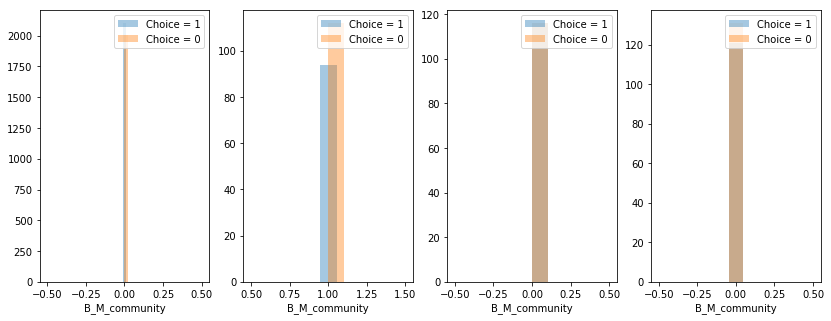

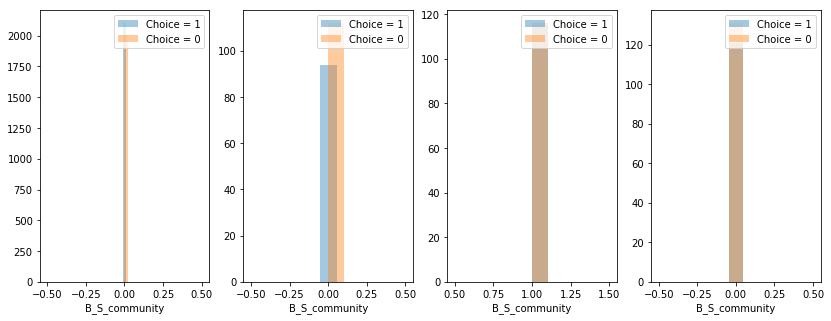

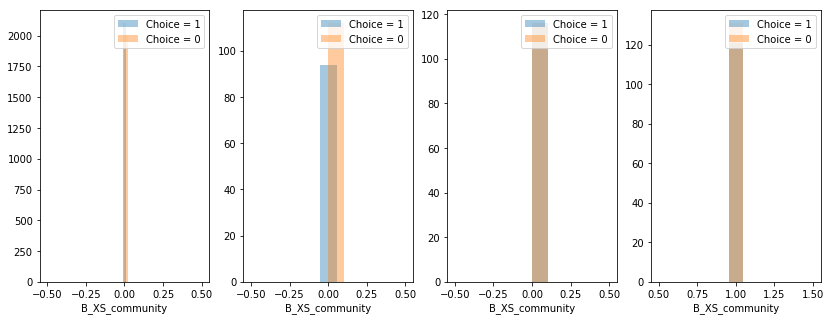

In [50]:
# Plot the features 
for i, col in enumerate(partitioned_nw.columns,start=1):
    plt.figure(i,figsize=(14, 5))
    for j,s in enumerate(['L','M','S','XS'],start=1): 
    
        feature1 = large_n.query('A_' + s + '_community == 1 and B_' + s + '_community == 1 and Choice == 1')[col]
        feature0 = large_n.query('A_' + s + '_community == 1 and B_' + s + '_community == 1 and Choice == 0')[col]

        # distribution of each feature
        plt.subplot(1, 4, j)
        sns.distplot(feature1,kde=False)
        sns.distplot(feature0,kde=False)
        plt.legend({
                    'Choice = 1':feature1,
                    'Choice = 0':feature0
                   })

# Save to .csv

Save the partitioned network to a .csv file

In [51]:
# Save the network for further investigation
partitioned_nw.to_csv('PartitionedNetwork.csv')

In [52]:
partitioned_nw.head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
0,34,0,40,190,228,302,3,0.583979,0.100503,0.100503,...,0,1,1,0,0,0,0,1,0,0
1,33,1,39,113,21591,1179,228,90.456506,25.798292,5.709329,...,2,2,1,0,0,0,1,0,0,0
2,3,2,1,788,7310,1215,101,25.503644,9.556347,5.361519,...,3,3,0,0,1,0,0,0,1,0
3,39,3,38,99,20,7,2,7.690824,0.277306,1.331508,...,4,4,1,0,0,0,1,0,0,0
4,37,4,42,307,45589,862,2641,148.854279,36.998884,27.881768,...,4,4,1,0,0,0,1,0,0,0
